## 房屋销售价格预测

### 目标

要求对预测每栋房屋的销售价格，即对于测试集test.csv中的每隔个Id，预测对应的SalePrice变量的值。

### 评价指标：RMSE

即根据预测值的对数和观察到的房价对数之间的均方根误差对提交结果进行评估
$$ RMSE = \sqrt {\frac{\sum_{i=1}^N (y_i-\hat{y_i})^2}{N}} $$

<img src="./HousePrices/featurename.png">

## （一）分析数据指标

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
%matplotlib inline

In [2]:
# 导入训练数据集
train_data = pd.read_csv(r"D:/sql/数据集/house-prices-advanced-regression-techniques/train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 1、房价数据异常分析

In [4]:
pd.DataFrame(train_data["SalePrice"]).describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


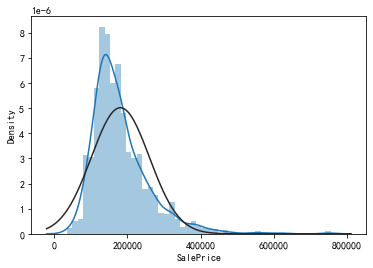

In [5]:
sns.distplot(train_data["SalePrice"],fit=norm)
plt.show()

In [6]:
print("Skewness:%f" % train_data["SalePrice"].skew())    # 偏度
print("Kurtusis:%f" % train_data["SalePrice"].kurt())    # 峰度

Skewness:1.882876
Kurtusis:6.536282


符合正态分布的特征，但偏度较大，需要作正态分布变化处理

### 2、一般规律下，居住面积越大房价越高，以此判断是否存在异常点

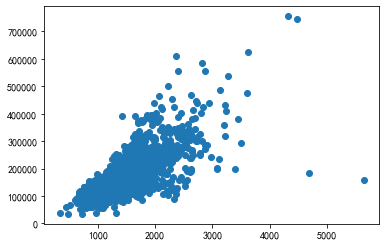

In [7]:
var = "GrLivArea"
data = train_data[["GrLivArea","SalePrice"]]
plt.scatter(x=data["GrLivArea"],y=data["SalePrice"])
plt.show()

从上图可以看出，存在离群点。

### 3、同样的，分析地下室面积与房价的关系，发现是否存在异常值

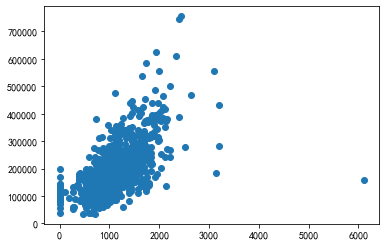

In [8]:
var_sf = "TotalBsmtSF"
data_sf = train_data[["TotalBsmtSF","SalePrice"]]
plt.scatter(x=data_sf["TotalBsmtSF"],y=data_sf["SalePrice"])
plt.show()
# 存在离群点

### 4、整体材料与饰面质量

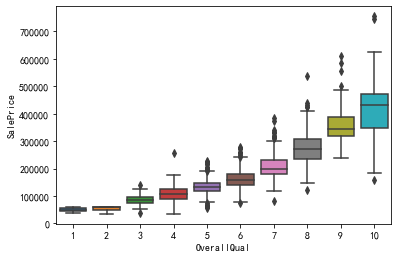

In [9]:
var_over = "OverallQual"
data_over = train_data[["OverallQual","SalePrice"]]
sns.boxplot(x=var_over,y="SalePrice",data=data_over)
plt.show()
# 从图中可以看出存在多数异常值

### 5、建造时间

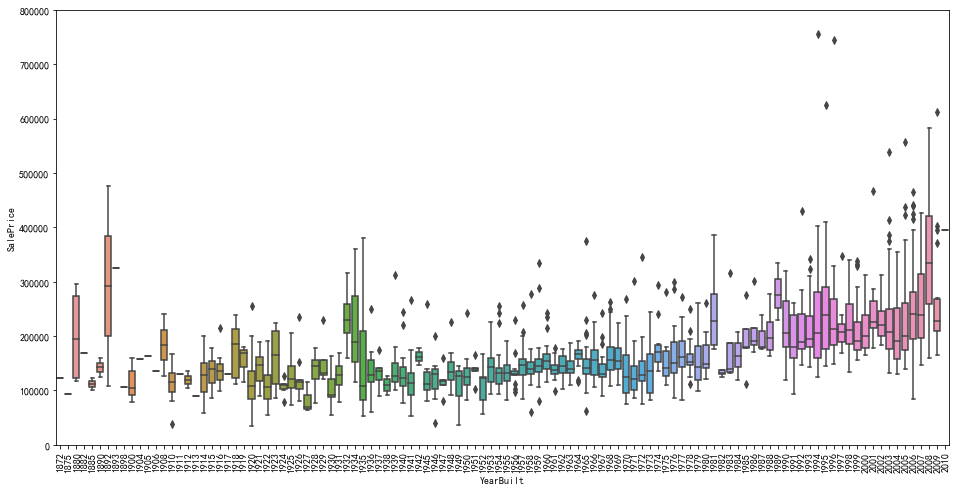

In [10]:
var_time = "YearBuilt"
data_time = train_data[["YearBuilt","SalePrice"]]
f,ax = plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var_time,y="SalePrice",data=data_time)
fig.axis(ymin=0,ymax=800000)
plt.xticks(rotation = 90)
plt.show()

### 6、除了建造年代越近，价格越贵的因素外，历史因素也是影响价格的一个重要原因。

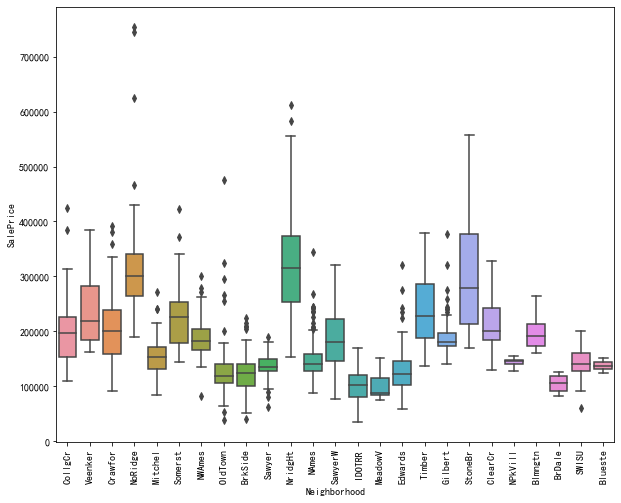

In [11]:
var_his = "Neighborhood"
data_his = train_data[["Neighborhood","SalePrice"]]
f,ax = plt.subplots(figsize=(10,8))
sns.boxplot(x=var_his,y="SalePrice",data=data_his)
plt.xticks(rotation = 90)
plt.show()

### 7、选出与房价关系最近的10个因素，找出它们之间的相关性

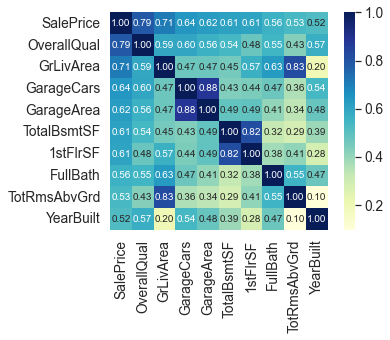

In [12]:
k = 10
corrmat = train_data.corr()
cols = corrmat.nlargest(k,"SalePrice")["SalePrice"].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt=".2f",annot_kws={'size':10},yticklabels=cols.values,
                xticklabels=cols.values,cmap="YlGnBu")
plt.show()

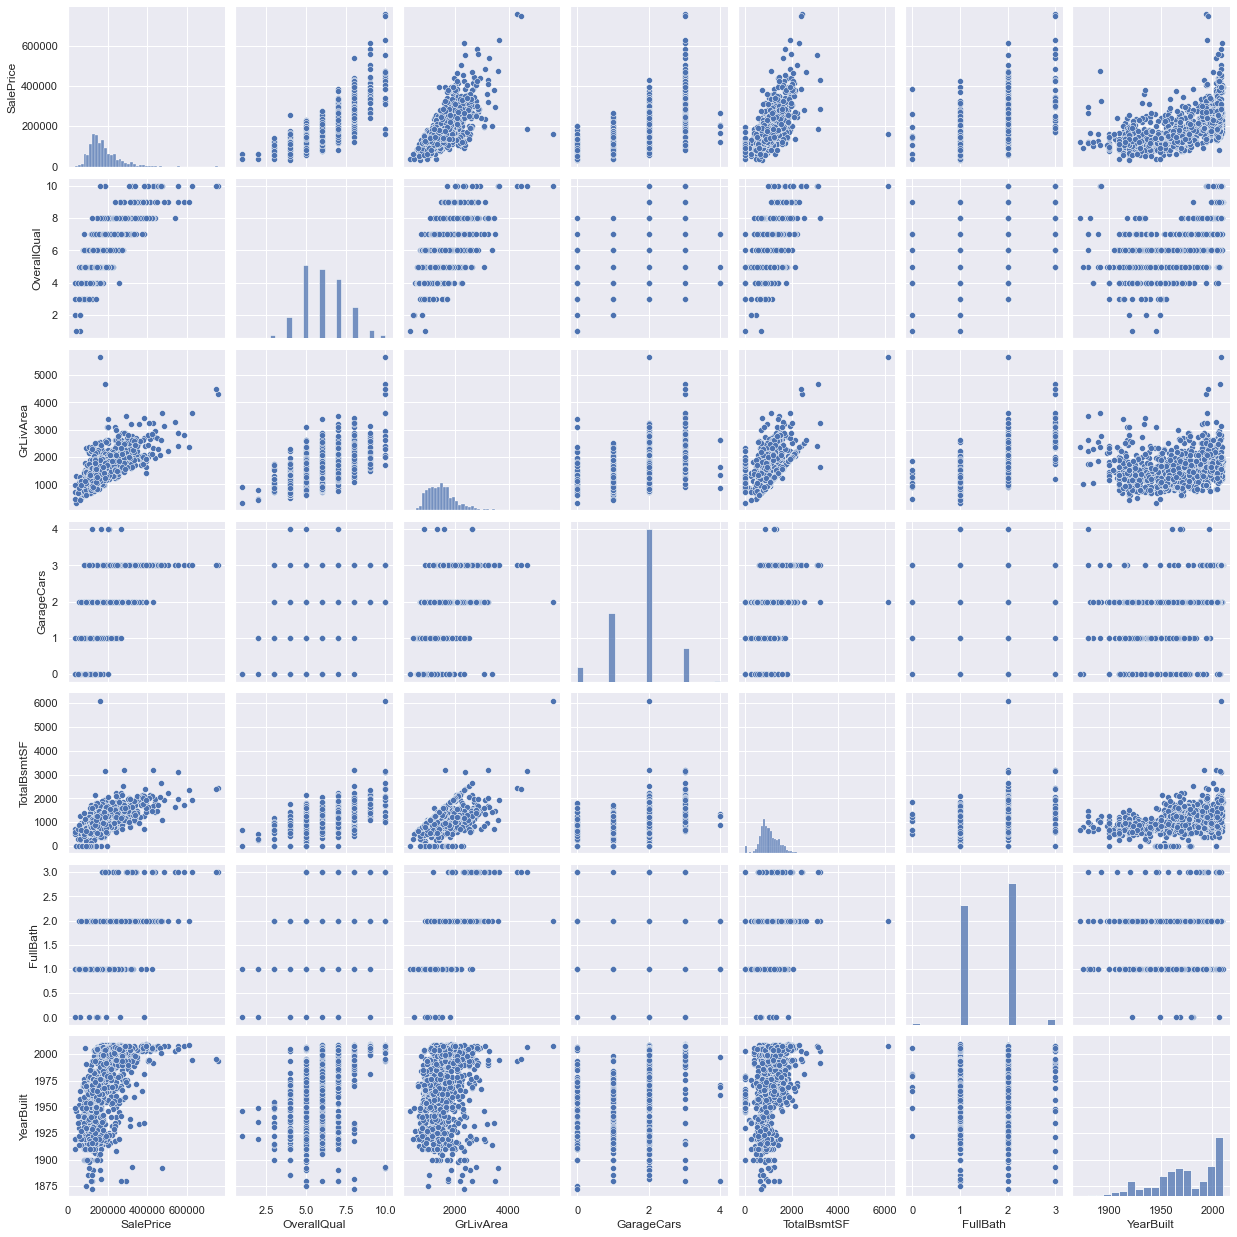

In [13]:
# scatterplot
sns.set()
cols = ["SalePrice","OverallQual","GrLivArea","GarageCars","TotalBsmtSF","FullBath","YearBuilt"]
sns.pairplot(train_data[cols],size=2.5)
plt.show()

总体上看，都符合特征值越往右，价格越贵，但是同时也存在离群点。

## （二）观察数据正态性

通过对数变换的方法，使得数据更加拟合正态分布。

转换数据前数据的分布情况

In [14]:
from scipy import stats

mu=180921.19589,sigma=79415.29189


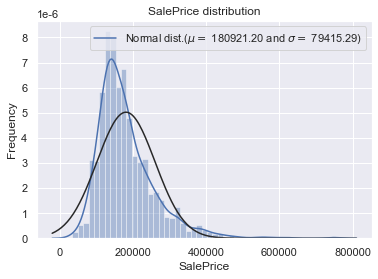

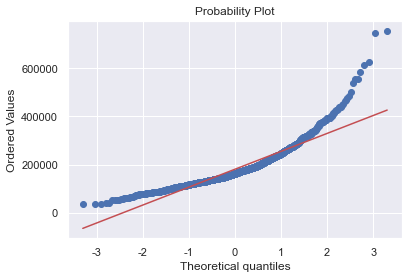

In [15]:
sns.distplot(train_data["SalePrice"],fit=norm)

(mu,sigma) = norm.fit(train_data["SalePrice"])

print("mu=%.5f,sigma=%.5f" %(mu,sigma))        # mu=180921.19589041095,   sigma = 79415.29188606751

plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)])
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

# q-q图
fig = plt.figure()
res = stats.probplot(train_data["SalePrice"],plot=plt)
plt.show()

转换后的数据分布情况

mu=12.02,sigma=0.40


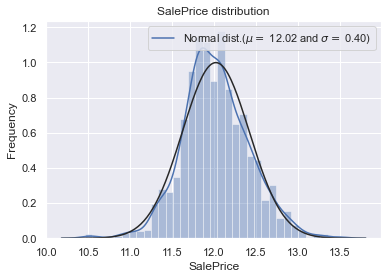

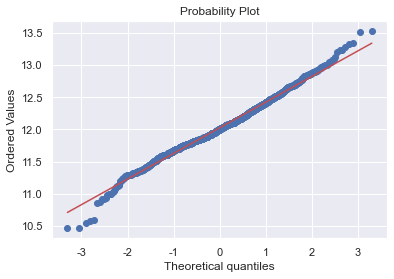

In [16]:
# 数据对数变换log(1+x)
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

# 数据变换后的分布
sns.distplot(train_data["SalePrice"],fit=norm)

# 参数
(mu,sigma) = norm.fit(train_data["SalePrice"])
print("mu=%.2f,sigma=%.2f" %(mu,sigma))

plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)])
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

fig = plt.figure()
res = stats.probplot(train_data["SalePrice"],plot=plt)
plt.show()

## （三）数据预处理

数据缺失值处理

In [17]:
total = train_data.isnull().sum().sort_values(ascending=False)
present = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,present],axis=1,keys=['Total','Precent'])
missing_data.head(10)

,Total,Precent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [18]:
# 去除ID列
train = train_data
test = pd.read_csv(r"D:/sql/数据集/house-prices-advanced-regression-techniques/test.csv")
# 查看数据有多大
print("the train data size before dropping id feature is : {}" .format(train.shape))
print("the test data size before dropping id feature is : {}" .format(test.shape))

train_ID = train["Id"]
test_ID = test["Id"]

train.drop("Id",axis=1,inplace=True)
test.drop("Id",axis=1,inplace=True)

the train data size before dropping id feature is : (1460, 81)
the test data size before dropping id feature is : (1459, 80)


发现离群点

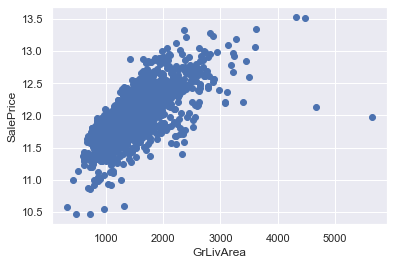

In [19]:
fig,ax = plt.subplots()
ax.scatter(x=train["GrLivArea"],y = train["SalePrice"])
plt.ylabel("SalePrice",fontsize=12)
plt.xlabel("GrLivArea",fontsize=12)
plt.show()

去除离群点

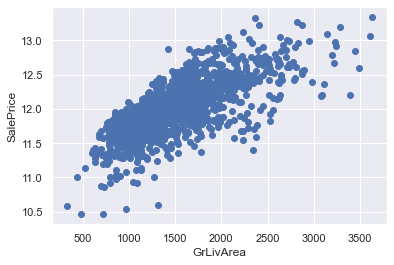

In [20]:
train = train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index)

# check
fig,ax = plt.subplots()
ax.scatter(x=train["GrLivArea"],y = train["SalePrice"])
plt.ylabel("SalePrice",fontsize=12)
plt.xlabel("GrLivArea",fontsize=12)
plt.show()

缺失值处理

将测试集与训练集项相连

In [21]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train["SalePrice"].values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(["SalePrice"],axis=1,inplace=True)
print("all_data size is {}".format(all_data.shape))

all_data size is (2915, 79)


In [22]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
all_data_na
missing_data = pd.DataFrame({"Missing Ratio":all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageFinish,5.454545
GarageQual,5.454545
GarageCond,5.454545
GarageYrBlt,5.454545


Text(0.5, 1.0, 'Percent missing data by feature')

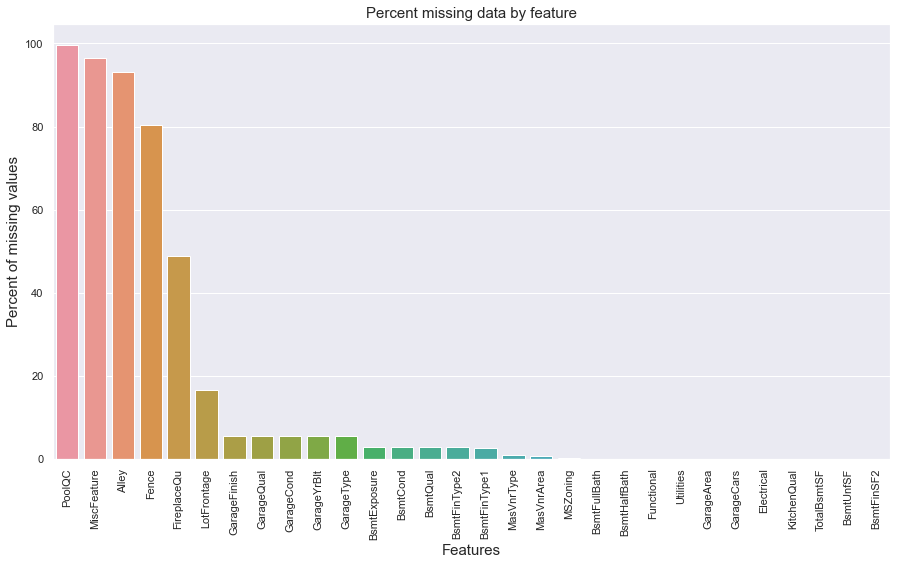

In [23]:
f,ax = plt.subplots(figsize=(15,8))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index,y=all_data_na)
plt.xlabel("Features",fontsize=15)
plt.ylabel("Percent of missing values",fontsize=15)
plt.title("Percent missing data by feature",fontsize=15)

由于缺失值很多，应按照各个特征值的特点去填充

In [24]:
# 游泳池
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [25]:
# 没有特征
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
# 通道入口
all_data["Alley"] = all_data["Alley"].fillna("None")
# 栅栏
all_data["Fence"] = all_data["Fence"].fillna("None")
# 壁炉
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
# 到街道的距离
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(all_data["LotFrontage"].mean())
# 车库
for col in ["GarageType","GarageFinish","GarageQual","GarageCond"]:
    all_data[col] = all_data[col].fillna("None")
for col in ["GarageYrBlt","GarageArea","GarageCars"]:
    all_data[col] = all_data[col].fillna(0)
# 地下室
for col in ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath"]:
    all_data[col] = all_data[col].fillna(0)
for col in ["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"]:
    all_data[col] = all_data[col].fillna("None")
# 砌体
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")

In [26]:
# 一般分类区
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])
# 家庭功能
all_data["Functional"] = all_data["Functional"].fillna("Typ")
# 电力系统
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])
# 厨房品质
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0])
# 外部
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0])
# 销售类型
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])
# 建筑类型
all_data["MSSubClass"] = all_data["MSSubClass"].fillna("None")

In [27]:
all_data = all_data.drop(["Utilities"],axis=1)

In [28]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio":all_data_na})
missing_data.head()

,Missing Ratio


另外，某些特征值是数字，但它并不是连续型数据，而是离散的，将它们转换为文本格式

In [29]:
all_data["MSSubClass"] = all_data["MSSubClass"].apply("str")

In [30]:
all_data["OverallCond"] = all_data["OverallCond"].astype(str)
all_data["YrSold"] = all_data["YrSold"].astype(str)
all_data["MoSold"] = all_data["MoSold"].astype(str)

使用sklearn.prerocessing中的LabelEncoder将其标签化

In [31]:
from sklearn.preprocessing import LabelEncoder
cols = ("FireplaceQu","BsmtQual","BsmtCond","GarageQual","GarageCond","ExterQual","ExterCond","HeatingQC",
       "PoolQC","KitchenQual","BsmtFinType1","BsmtFinType2","Functional","Fence","BsmtExposure","GarageFinish",
       "LandSlope","LotShape","PavedDrive","Street","Alley","CentralAir","MSSubClass","OverallCond","YrSold",
       "MoSold")

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print("Shape all_data:{}".format(all_data.shape))

Shape all_data:(2915, 78)


In [32]:
# 增加一个新特征--总面积
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]

### 连续型数据正态性处理

先看数据

In [33]:
from scipy.stats import norm,skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features:\n")
skewness = pd.DataFrame({"Skew":skewed_feats})
skewness.head(10)


Skew in numerical features:



,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
LandSlope,4.971350
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508


选择偏度大于0.75的特征值，通过scipy.special 的boxcox1p进行转换

In [34]:
skewness = skewness[skewness["Skew"]>0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 21 skewed numerical features to Box Cox transform


In [35]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat],lam)

之后通过pd.get_dummies将数据转为one-hot编码

In [36]:
all_data = pd.get_dummies(all_data)
train = all_data[:ntrain]
test = all_data[ntrain:]

## （四）建模预测房价

In [37]:
from sklearn.linear_model import ElasticNet,Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [38]:
# 定义X,y
X = train
y = y_train

In [39]:
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds,shuffle=True,random_state=50).get_n_splits(X)
    rmse = np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=kf))
    return rmse

make_pipeline：级联  
RobustScaler：标准化  适合处理离群点

In [40]:
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=50))

ElasticNet同时L1、L2正则

In [41]:
ENet = make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=50))

In [42]:
KRR = KernelRidge(alpha=0.6,kernel="polynomial",degree = 2,coef0=2.5)

In [43]:
GBoost = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,max_features="sqrt",
                                  min_samples_leaf=15,min_samples_split=10,loss="huber",
                                  random_state=50)

In [44]:
model_xgb = xgb.XGBRFRegressor(colsample_bytree=0.4603,gamma=0.0468,learning_rate=0.05,max_depth=3,
                              min_child_weight=1.7817,n_estimators=2200,reg_lambda=0.8571,reg_alpha=0.4640,
                              subsample=0.5213,nthread=-1)

In [45]:
models = [lasso,ENet,KRR,GBoost,model_xgb]
model_names = ["lasso","ENet","KRR","GBoost","model_xgb"]
scores = {}

for i,model in enumerate(models):
    score = rmsle_cv(model)
    print("{}rmse score:{:.4f},rmse std:{:.4f}".format(model_names[i],score.mean(),score.std()))
    scores[model_names[i]] = (score.mean(),score.std())

rmse_df = pd.DataFrame(scores,index=["rmse_score","rmse_std"])
rmse_df.sort_values("rmse_score",axis=1,inplace=True)
rmse_df

lassormse score:0.1101,rmse std:0.0069
ENetrmse score:0.1101,rmse std:0.0070
KRRrmse score:0.2622,rmse std:0.0149
GBoostrmse score:0.1163,rmse std:0.0074
model_xgbrmse score:10.9538,rmse std:0.0175


,ENet,lasso,GBoost,KRR,model_xgb
rmse_score,0.110052,0.110109,0.116289,0.262158,10.953832
rmse_std,0.006966,0.006932,0.007358,0.014942,0.017527


上述模型中，ENet与lasso表现最好

创建一个平均模型

In [46]:
class AverageModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models = models
    
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.models]
    
        for model in self.models_:
            model.fit(X,y)
        
        return self
    
    def predict(self,X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions,axis=1)

In [47]:
average_models = AverageModels(models=(ENet,GBoost,KRR,lasso))

score = rmsle_cv(average_models)
score.mean(),score.std()

(0.12024838253600564, 0.004899751127448171)

使用ENet模型对数据进行预测

In [52]:
ENet.fit(X,y)
enet_pre = ENet.predict(test.values)
enet_pre
y_enet = pd.DataFrame()
y_enet["ID"] = test_ID
y_enet["SalePrice"] = np.expm1(enet_pre)
y_enet

,ID,SalePrice
0,1461,119482.836667
1,1462,153986.317555
2,1463,181810.347038
3,1464,196415.192727
4,1465,198569.379177
...,...,...
1454,2915,89071.364167
1455,2916,84123.348574
1456,2917,176179.291511
1457,2918,117479.981674


In [53]:
y_enet.to_csv("enet.csv",index=False)

使用平均模型预测

In [54]:
average_models.fit(X,y)
average_pre = average_models.predict(test.values)
y_average = pd.DataFrame()
y_average["ID"] = test_ID
y_average["SalePrice"] = np.expm1(average_pre)
y_average

,ID,SalePrice
0,1461,123299.503788
1,1462,158762.272303
2,1463,187340.409755
3,1464,196675.667852
4,1465,191204.119376
...,...,...
1454,2915,75413.040360
1455,2916,80456.831022
1456,2917,169047.890219
1457,2918,128940.769049


In [55]:
y_average.to_csv("average.csv",index=False)